In [1]:
import sys
from os import getcwd
from os.path import join
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns

sys.path.insert(0, join(getcwd(), "../module_code"))

from data.load import load_data, load_outcomes
from data.utils import read_files_and_combine
from cli_utils import load_cli_args, init_cli_args

sys.argv = [sys.argv[0]]
load_cli_args("../options.yml")
args = init_cli_args()

/home/davina/mambaforge/envs/crrt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vitals

In [25]:
vitals = "Flowsheet_Vitals.txt"
crrt_df = read_files_and_combine([vitals], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([vitals], args.ucla_control_data_dir)
cedars_df = read_files_and_combine([vitals], args.cedars_crrt_data_dir)

mealy | WARNING - Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
mealy | WARNING - Skipping bad lines...


In [ ]:
crrt_df[crrt_df["VITAL_SIGN_TYPE"].str.lower().str.contains("weight")]

,IP_PATIENT_ID,IP_ENCOUNTER_ID,VITAL_SIGN_SOURCE,VITAL_SIGN_TYPE,VITAL_SIGN_TAKEN_TIME,VITAL_SIGN_VALUE
6,CC4BD14F139815E54536BE37135576D1,AC8CCE78AE930AA23722440D81CF4CFF,FLOWSHEET,Weight,10/31/2018 04:30,1784.84
22,B8430952C347E5D247F690A331B2B7D5,094B742C5A60A14D6CF2B538D878FFA1,FLOWSHEET,Weight,10/24/2018 04:00,3287.5
44,FC39375C45A6C0B029BB9EA3F1D10DAF,7F9FF6E90D8D3AA8A80F632F4CE05A31,FLOWSHEET,Weight,10/25/2018 06:00,3174.62
54,2DA575F5D19C4D9EC2B7CB102E714F9B,BDABDCE5E9B6EDEF45745A0F2CB37448,FLOWSHEET,Weight,10/04/2018 05:00,2934.76
92,72BADF36EDC51E7C78528801BD0954F0,44C52C273D2E111CF3B34D6D2485F0C9,FLOWSHEET,Weight,10/14/2018 06:00,2246.93
...,...,...,...,...,...,...
36504,5B8CCC9969C7AAC2A396F96579CAE828,D0BABCFB493C632E734735FB82B0C587,FLOWSHEET,Weight,08/28/2021 06:29,2452.8
36509,44A97736C0B7E1EE2BF61CAC8C0A1D7D,1825A7D728A5B46985FDCA10C158EF79,FLOWSHEET,Weight,08/29/2021 06:00,2371.2
36521,D60F511C1B7D5BD2766AEC790820FBE6,1E9474A612F2521073085AD1895B5AFB,FLOWSHEET,Weight,08/25/2021 05:45,2052.92
36523,4FC72EA12F7F9BE3A4687E7A9903D4CA,F83CBE64DB7E8CC1E58A3DE066794047,FLOWSHEET,Weight,08/17/2020 05:00,2490.32


In [ ]:
cedars_df[cedars_df["MEAS_NAME"].str.lower().str.contains("weight")]

,UNNAMED: 0,IP_PATIENT_ID,INPATIENT_DATA_ID,MEAS_NAME,MEAS_VALUE,RECORDED_TIME
90,90,13476959543,77379674750,WEIGHT_OZ,3588.8,2017-04-02 05:25:00
111,111,25690503960,28876926928,WEIGHT_OZ,4409.2,2017-09-28 06:22:00
133,133,74794011114,45241455855,WEIGHT_OZ,2102.4,2017-01-30 05:00:00
196,196,94386067142,79276829248,WEIGHT_OZ,2368,2017-04-13 21:00:00
216,216,33575266117,71444246739,WEIGHT_OZ,2481.6,2017-03-08 23:40:00
...,...,...,...,...,...,...
1048128,1048128,22203651728,90499999661,WEIGHT_OZ,NaN,2017-01-13 20:05:00
1048159,1048159,68300600483,96632796349,WEIGHT_OZ,2428.8,2017-07-17 06:09:00
1048210,1048210,78430548053,75134348270,WEIGHT_OZ,3152,2017-01-14 06:00:00
1048335,1048335,63405451507,98844171621,WEIGHT_OZ,4109.37,2017-01-14 05:13:00


# Labs

In [2]:
from data.longitudinal_features import map_labs

labs = "Labs.txt"

crrt_df = read_files_and_combine([labs], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([labs], args.ucla_control_data_dir)
cedars_df = read_files_and_combine([labs], args.cedars_crrt_data_dir).rename(
    {"RESULT": "RESULTS", "NAME": "COMPONENT_NAME"}, axis=1
)
cedars_df = map_labs(cedars_df, args.cedars_crrt_data_dir)

mealy | WARNING - Unexpected encoding in Labs.txt. Encoding with cp1252.


In [3]:
# ucla_units = crrt_df.groupby("DESCRIPTION")["REFERENCE_UNIT"]
ucla_units = crrt_df.groupby("COMPONENT_NAME")["REFERENCE_UNIT"]
cedars_units = cedars_df.groupby("COMPONENT_NAME")["REFERENCE_UNIT"]

In [45]:
def del_key(key, d: dict) -> dict:
    if d:
        d.pop(key, None)
    return d


def units_per_lab(group: pd.Series) -> bool:
    # a = group.dropna().str.lower()
    a = group.dropna().str.lower().value_counts()
    if not group.isna().all():
        # mode = a.mode().values[0]
        mode = a.idxmax()
        mode_count = a[mode]
        if (a.iloc[0] == a).all():
            return {"mode_unit": {mode: mode_count}, "other_ucla_units": {}}
        else:
            return {
                "mode_unit": {mode: mode_count},
                "other_ucla_units": del_key(mode, a.to_dict()),
            }
    return None


ucla_unmatched_internal = pd.DataFrame(ucla_units.agg(units_per_lab).to_dict()).T
ucla_unmatched_internal

,mode_unit,other_ucla_units
"O2 SATURATION/MEASURED,ECMO PREMEMBRANE",{'%': 1178},{}
% CD16+CD56 (NK CELLS),{'%': 2},{}
% CD19 (B CELLS),{'%': 2},{}
% CD19 (B CELLS)(QST),{'%': 1},{}
% CD3 (MATURE T CELLS)(QST),{'%': 3},{}
...,...,...
"ZINC,SERUM",{'mcg/ml': 842},{}
"ZINC,SERUM(OSL)",None,None
"ZZBENZODIAZEPINES,SCREEN,SERUM",None,None
"ZZTRICYCLIC AD,SCREEN,SERUM",None,None


In [5]:
# cedar_units_sets = cedars_units.agg(
#     lambda group: set(group.dropna().str.lower()) if not group.isna().all() else set()
# ).rename("cedars units")
cedars_unit_counts = cedars_units.agg(
    lambda group: group.dropna().str.lower().value_counts().to_dict()
    if not group.isna().all()
    else {}
).rename("cedars_units")
cedars_unit_counts

COMPONENT_NAME
% CD3 (T CELLS)                             {'%': 3}
% OF CELLS COUNTED                                {}
% RELEASE, HIGH DOSE                       {'%': 17}
% RELEASE, LOW DOSE                        {'%': 17}
%VO2 MAX STEADY STATE LEVEL 1 (PFT)         {'%': 1}
                                           ...      
WHOLE BLOOD ACT-KAOLIN (POC)           {'sec': 1739}
WORK PEAK VO2 PRED (PFT)                {'watts': 1}
WORK-TM STEADY STATE LEVEL 1 (PFT)      {'watts': 1}
YEAST                                  {'/hpf': 101}
ZINC                                    {'ug/dl': 5}
Name: cedars_units, Length: 1369, dtype: object

In [53]:
combined = (
    ucla_unmatched_internal.dropna(subset="other_ucla_units")
    .join(cedars_unit_counts)
    .replace({"cedars_units": {np.nan: {}}})
)
def add_mode_count_from_cedars(row):
    mode = next(iter(row["mode_unit"]))
    count = row["mode_unit"][mode]
    count += row["cedars_units"].get(mode, 0)
    return {mode: count}

combined["mode_unit"] = combined.apply(add_mode_count_from_cedars, axis=1)
combined["cedars_units"] = combined.apply(
    lambda row: del_key(next(iter(row["mode_unit"])), row["cedars_units"]), axis=1
)
combined["combined_units"] = pd.Series(
    [
        # set1.union(set2) - {mode}
        # sum the counts
        # https://stackoverflow.com/a/10461916/1888794
        del_key(next(iter(mode)), {k: set1.get(k, 0) + set2.get(k, 0) for k in set(set1) | set(set2)})
        for set1, set2, mode in zip(
            combined["other_ucla_units"],
            combined["cedars_units"],
            combined["mode_unit"],
        )
    ],
    index=combined.index,
)
combined

,mode_unit,other_ucla_units,cedars_units,combined_units
"O2 SATURATION/MEASURED,ECMO PREMEMBRANE",{'%': 1178},{},{},{}
% CD16+CD56 (NK CELLS),{'%': 2},{},{},{}
% CD19 (B CELLS),{'%': 2},{},{},{}
% CD19 (B CELLS)(QST),{'%': 1},{},{},{}
% CD3 (MATURE T CELLS)(QST),{'%': 3},{},{},{}
...,...,...,...,...
"ZINC, URINE - PER 24H",{'ug/d': 1},{},{},{}
"ZINC, URINE - PER VOLUME",{'ug/dl': 1},{},{},{}
"ZINC, URINE - RATIO TO CRT",{'ug/g crt': 1},{},{},{}
"ZINC,SERUM",{'mcg/ml': 842},{},{},{}


In [54]:
# Columns that are actually used by the model with different units
import pickle

columns_path = join("..", "local_data", "columns.pkl")
with open(columns_path, "rb") as f:
    selected_cols = pickle.load(f)
colnames = selected_cols.str.rstrip("_len|max|min|skew|std").unique()
selected_cols_with_units = combined.loc[colnames.intersection(combined.index)]
selected_cols_with_units[selected_cols_with_units["combined_units"] != {}]

,mode_unit,other_ucla_units,cedars_units,combined_units
24 HR. URINE VOLUME,{'ml': 23},{'ml/24 h': 5},{},{'ml/24 h': 5}
ABSOLUTE BASOPHILS(QST),{'cells/ul': 1880},{'x10*9/l': 8},{},{'x10*9/l': 8}
ABSOLUTE EOSINOPHILS(QST),{'cells/ul': 1880},{'x10*9/l': 8},{},{'x10*9/l': 8}
ABSOLUTE LYMPHOCYTE COUNT,{'x10e3/ul': 110832},{},{'1000/ul': 2952},{'1000/ul': 2952}
ABSOLUTE LYMPHOCYTES(QST),{'cells/ul': 1883},{'x10*9/l': 13},{},{'x10*9/l': 13}
...,...,...,...,...
"WBC,UR(QST)",{'/hpf': 131},{'per hpf': 3},{},{'per hpf': 3}
WBCS,{'cells/ul': 18993},{'/ul': 55},{},{'/ul': 55}
WHITE BLOOD CELL COUNT(QST),{'thousand/ul': 2009},{'x10*9/l': 13},{},{'x10*9/l': 13}
WHITE BLOOD CELL COUNT,{'x10e3/ul': 279549},{},{'1000/ul': 14347},{'1000/ul': 14347}


In [55]:
# any_mismatch_units = selected_cols_with_units[selected_cols_with_units["combined_units"] != {}]
# any_mismatch_units
any_mismatch_units = combined[combined["combined_units"] != {}]
any_mismatch_units

,mode_unit,other_ucla_units,cedars_units,combined_units
24 HR. URINE VOLUME,{'ml': 23},{'ml/24 h': 5},{},{'ml/24 h': 5}
ABSOLUTE BASOPHILS(QST),{'cells/ul': 1880},{'x10*9/l': 8},{},{'x10*9/l': 8}
ABSOLUTE EOSINOPHILS(QST),{'cells/ul': 1880},{'x10*9/l': 8},{},{'x10*9/l': 8}
ABSOLUTE LYMPHOCYTE COUNT,{'x10e3/ul': 110832},{},{'1000/ul': 2952},{'1000/ul': 2952}
ABSOLUTE LYMPHOCYTES(QST),{'cells/ul': 1883},{'x10*9/l': 13},{},{'x10*9/l': 13}
...,...,...,...,...
"WBC,UR(QST)",{'/hpf': 131},{'per hpf': 3},{},{'per hpf': 3}
WBCS,{'cells/ul': 18993},{'/ul': 55},{},{'/ul': 55}
WHITE BLOOD CELL COUNT,{'x10e3/ul': 279549},{},{'1000/ul': 14347},{'1000/ul': 14347}
WHITE BLOOD CELL COUNT(QST),{'thousand/ul': 2009},{'x10*9/l': 13},{},{'x10*9/l': 13}


Unit conversion resources:
- [LOINC Table CSV](https://github.com/shihjay2/nosh2/blob/master/resources/LOINC.csv)
- [LOINC Web Lookup](https://www.vas.ehealth.fgov.be/webretam/retam/home.htm?eventName=LOINC_FILTER_APPLY&htmlfield_analysesId=&htmlfield_assoc=no&htmlfield_filter1=5403-1&htmlfield_searchin_filter1=all&htmlfield_filter2=&htmlfield_searchin_filter2=all&htmlfield_filter3=&htmlfield_searchin_filter3=all)
- [Units and Abbreviations](https://www.aruplab.com/files/resources/testing/KeyUnitsAbbrev.pdf)
- [Unit string variations](https://www.cdc.gov/cliac/docs/addenda/cliac0313/13A_CLIAC_2013March_UnitsOfMeasure.pdf)

In [56]:
equivalents = [  # map mode to others
    {"/hpf", "per hpf"},
    {"ml", "ml/24 h"},  # 24 HR. URINE VOLUME
    {"cells/ul", "/ul"},  # WBCS and others
    {"%", "% normal"},  # VWF: RISTOCETIN CO-FACTOR
    {"%", "% binding inhibition"},
    {"%", "% baseline"},
    {"%", "% of total"},
    {"%", "% activity"},
    {"%", "g/dl"},
    {"cpy/ml", "copiesml"},
    {"uge/ml", "mcg eq/ml", "ug eq/ml"},
    {"units/ml", "% normal"},
    {"mg/dl", "mg/dl adult"},
    {"au/ml", "u/ml", "titer"},
    {"ng/ml feu", "ng/mlfeu"},
    {"ml/min/1.73m2", "ml/min/bsa", "ml/min/1.73", "ml/min/1.73m", "ml/min"},
    {"mg/dl", "md/dl", "mg/di"},  # typo
    {"ng/ml", "ng/ml rbc"},
    {"au/ml", "ai"},
    {"u/g hgb", "u/g hb"},
    {"liv", "index"},  # LYME DISEASE AB,TOTAL
    {"ng/ml", "eia unit"},
    # ("fl = femtoliter = cu mic = cubic micron")
    {"fl", "cu mic"},
    {"nmol bce/mmol creat", "nm bce/mm creat"},
    {"m2", "meters s"},
    {"pg/mlcdf", "pg/ml"},
    {"m/ul", "mi/mm3", "m/mm3", "x10e6/ul"},
    {"iv", "IV", "index", "INDEX"},
]
# https://www.cdc.gov/cliac/docs/addenda/cliac0313/13A_CLIAC_2013March_UnitsOfMeasure.pdf
count_units = {
    "x10e3": 1e3,
    "thousand": 1e3,
    "thous": 1e3,
    "1000": 1e3,
    "10e3": 1e3,
    "k": 1e3,
    "x10e6": 1e6,
    "10e6": 1e6,
    "mill": 1e6,
    "million": 1e6,
    "X10*9": 1e9,
    "x10*9": 1e9,
    "x10*12": 1e12,
    "cells": 1,
}
mol_to_eq = {  # meq/mol
    "ANION GAP": 1,
    "BASE EXCESS": 1,
    "BICARBONATE": 1,
    "CARBON DIOXIDE": 1,
    "CHLORIDE": 1,
    "MAGNESIUM": 2,
    "PHOSPHORUS": 3,  # 3 or 5
    "POTASSIUM": 1,
    "SODIUM": 1,
}
g_to_mol = {  # inverse of molecular weight, so mol/g
    "AMMONIA": 0.058719906,
    "BETA-HYDROXYBUTYRATE": 0.009605,
    "CREATININE": 0.008842,
    "CREATININE, RANDOM URINE": 0.008842,
    "CREATININE,RANDOM URINE": 0.008842,
    "LIPOPROTEIN (A)": 0.0028011204,
    "MAGNESIUM": 0.0411438,
    "METANEPHRINE": 0.0050702226,
    "METANEPHRINE, FREE PLASMA": 0.0050702226,
    "NORMETANEPHRINE, FREE PLASMA": 0.0050702226,
    "PTH-RELATED PROTEIN (PTH-RP)": 0.0001061008,
    "VITAMIN B6": 0.0059101655,
    "VITAMIN C": 0.0056818182,
}
# timed + LIPOPROTEIN (A)

In [57]:
from pint import UnitRegistry, Quantity, UndefinedUnitError, DimensionalityError
ureg = UnitRegistry()
# https://pint.readthedocs.io/en/stable/advanced/defining.html#programmatically
ureg.define("micro- = 1e-6 = u = mc")
ureg.define("iu = u")
ureg.define("mm3 = mm**3")
ureg.define("eq = equivalent")
def convert(a, b) -> Quantity:
    return ureg(a).to(b)
convert("10 iu/l", "u/l")

mealy | WARNING - Redefining 'micro' (<class 'pint.delegates.txt_defparser.plain.PrefixDefinition'>)
mealy | WARNING - Redefining 'u' (<class 'pint.delegates.txt_defparser.plain.PrefixDefinition'>)


10.0 <Unit('unified_atomic_mass_unit / liter')>

In [58]:
def cant_auto_convert(row):
    mode = next(iter(row["mode_unit"]))
    cant_convert = {}
    for other_unit, count in row["combined_units"].items():
        try:
            if not any(
                mode in equiv_set and other_unit in equiv_set
                for equiv_set in equivalents
            ):
                # time 
                def proc_unit(unit):
                    # drop (calc) and creat
                    unit = unit.replace("(calc)","")
                    unit = unit.replace("creat","")
                    unit = unit.replace("crt","")

                    if "/24" in unit:
                        return unit.split("/")[0] + "/d"
                    return unit
                mode = proc_unit(mode)
                other_unit = proc_unit(other_unit)

                # import difflib
                conv_eq_to_mol = ("mol" in mode or "g" in mode) and "eq" in other_unit
                conv_mol_to_eq = "eq" in mode and "mol" in other_unit 
                conv_g_to_eq = "eq" in mode and "g" in other_unit

                # do i need valence/charge
                if conv_eq_to_mol or conv_mol_to_eq:
                    print("[[MOL <-> EQ]]")
                    name = next(iter([k for k in mol_to_eq if k in row.name]), None)
                    if conv_eq_to_mol:
                        print(
                            f"Convert {other_unit} to {mode} for {row.name}: val * {1/mol_to_eq[name]}"
                        )
                        other_unit = other_unit.replace("eq", "mol")
                    elif conv_mol_to_eq:
                        print(
                            f"Convert {other_unit} to {mode} for {row.name}: val * {mol_to_eq[name]}"
                        )
                        other_unit = other_unit.replace("mol", "eq")
                # print("\n".join(difflib.ndiff([str(mode)], ["x10e3/ul"])))
                conv_g_to_mol = "mol" in mode and "g" in other_unit
                conv_mol_to_g = "g" in mode and "mol" in other_unit
                # pick longest match
                count_unit_convert_mode = sorted(
                    [count for count in count_units if count in mode],
                    key=len,
                    reverse=True,
                )
                count_unit_convert_other = sorted(
                    [count for count in count_units if count in other_unit],
                    key=len,
                    reverse=True,
                )

                # do i need molecular weight
                if (conv_g_to_mol or conv_g_to_eq) or conv_mol_to_g:
                    print("[[MOL <-> G]]")
                    if conv_g_to_eq:
                        print("[[MOL <-> EQ]]")
                        name = next(iter([k for k in mol_to_eq if k in row.name]), None)
                        v = convert(other_unit.replace("g", "mol"), mode.replace("eq", "mol"))
                        print(
                            f"Convert {other_unit} to {mode} for {row.name}: val * {v} * {g_to_mol[row.name]} mol/g * {mol_to_eq[name]} eq/mol"
                        )
                    elif conv_g_to_mol:
                        v = convert(other_unit.replace("g", "mol"), mode)
                        print(
                            f"Convert {other_unit} to {mode} for {row.name}: val * {v} * {g_to_mol[row.name]} mol/g"
                        )
                    elif conv_mol_to_g:
                        v = convert(other_unit.replace("mol", "g"), mode)
                        name = next(iter([k for k in g_to_mol if k in row.name]), None)
                        print(
                            f"Convert {other_unit} to {mode} for {row.name}: val * {v} * {1/g_to_mol.get(name, -1)} g/mol"
                        )
                elif count_unit_convert_mode or count_unit_convert_other:
                    print("[[Named Units]]")
                    to_convert_mode = next(iter(count_unit_convert_mode), "")
                    to_convert_other = next(iter(count_unit_convert_other), "")
                    other_name = (
                        other_unit.replace(to_convert_other, "u")
                        if to_convert_other
                        else other_unit
                    )
                    mode_name = (
                        mode.replace(to_convert_mode, "u") if to_convert_mode else mode
                    )
                    v = convert(other_name, mode_name)
                    print(
                        f"Convert {other_unit} to {mode} for {row.name}: val * {v} * {count_units.get(to_convert_other,1)} / {count_units.get(to_convert_mode, 1)}"
                    )
                else:
                    convert(other_unit, mode)
            else:
                print("[[EQUIV]]")
                print(
                    f"{other_unit} and {mode} for {row.name} are considered equivalent."
                )
        except UndefinedUnitError as e:
            print(f"[[ERROR]] ({row.name})\n{e}")
            cant_convert[other_unit] = count
        except DimensionalityError as e:
            print(f"[[ERROR]] ({row.name})\n{e}")
            cant_convert[other_unit] = count
        except ValueError as e:
            print(f"[[ERROR]] ({row.name})\n{e}")
            cant_convert[other_unit] = count
        except:
            print(row)
            cant_convert[other_unit] = count
    return cant_convert


# combined = combined.assign(cant_convert=lambda df: df.apply(cant_auto_convert, axis=1))
selected_cols_with_units = selected_cols_with_units.assign(cant_convert=lambda df: df.apply(cant_auto_convert, axis=1))

[[EQUIV]]
ml/24 h and ml for 24 HR. URINE VOLUME are considered equivalent.
[[Named Units]]
Convert x10*9/l to cells/ul for ABSOLUTE BASOPHILS(QST): val * 1e-06 unified_atomic_mass_unit / microliter * 1000000000.0 / 1
[[Named Units]]
Convert x10*9/l to cells/ul for ABSOLUTE EOSINOPHILS(QST): val * 1e-06 unified_atomic_mass_unit / microliter * 1000000000.0 / 1
[[Named Units]]
Convert 1000/ul to x10e3/ul for ABSOLUTE LYMPHOCYTE COUNT: val * 1.0 unified_atomic_mass_unit / microliter * 1000.0 / 1000.0
[[Named Units]]
Convert x10*9/l to cells/ul for ABSOLUTE LYMPHOCYTES(QST): val * 1e-06 unified_atomic_mass_unit / microliter * 1000000000.0 / 1
[[Named Units]]
Convert x10*9/l to cells/ul for ABSOLUTE MONOCYTES(QST): val * 1e-06 unified_atomic_mass_unit / microliter * 1000000000.0 / 1
[[Named Units]]
Convert x10*9/l to cells/ul for ABSOLUTE NEUTROPHILS(QST): val * 1e-06 unified_atomic_mass_unit / microliter * 1000000000.0 / 1
[[EQUIV]]
copiesml and cpy/ml for ADENOVIRUS DNA COPIES/ML are cons

In [65]:
# cant_convert = combined[combined["cant_convert"] != {}]
cant_convert = selected_cols_with_units[selected_cols_with_units["cant_convert"] != {}]
cant_convert.sort_values(by="mode_unit", ascending=False, key=lambda x: x.map(lambda y: next(iter(y.values()))))

,mode_unit,other_ucla_units,cedars_units,combined_units,cant_convert
RBC(LDQ),{'x10e6/ul': 1676},{'10': 1},{},{'10': 1},{'10': 1}
CK-MB,{'ng/ml': 1142},"{'%': 105, '% of total': 2}",{},"{'%': 105, '% of total': 2}","{'%': 105, '% of total': 2}"
TOTAL VOLUME,{'ml': 563},"{'ml/24hr': 7, 'ml/24 hr': 2}",{},"{'ml/24hr': 7, 'ml/24 hr': 2}",{'ml/d': 2}
RDW(LBC),{'%': 526},{'fl': 1},{},{'fl': 1},{'fl': 1}
T-UPTAKE,{'tbi': 264},{},{'%': 43},{'%': 43},{'%': 43}
"MESOTHELIAL,FLUID",{'%': 234},{},{'-': 7},{'-': 7},{'-': 7}
SQUAMOUS EPITHELIAL CELLS(QST),{'/hpf': 130},{'per lpf': 2},{},{'per lpf': 2},{'per lpf': 2}
"COMPLEMENT, TOTAL (CH50)",{'u/ml': 66},{'cae units': 48},{},{'cae units': 48},{'cae units': 48}
ANTITHROMBIN III ANTIGEN,{'%': 55},{'mg/dl': 18},{'mg/dl': 4},{'mg/dl': 22},{'mg/dl': 22}
"CH50, TOTAL COMPLEMENT",{'u/ml': 37},{'caeunits': 2},{},{'caeunits': 2},{'caeunits': 2}


In [49]:
# selected_cols_with_units.to_csv("lab_units_selected_columns.csv")

## Manually Check Equivalents

,IP_PATIENT_ID,IP_ENCOUNTER_ID,PROC_ID,DESCRIPTION,COMPONENT_ID,COMPONENT_NAME,ORDER_TIME,RESULT_TIME,SPECIMN_TAKEN_TIME,REFERENCE_UNIT,LOINC_CODE
RESULTS,,,,,,,,,,,
<0.1,True,True,True,True,True,True,True,True,True,True,True
<0.10,True,True,True,True,True,True,True,True,True,True,True
<0.11,True,True,True,True,True,True,True,True,True,True,True
<0.3,True,True,True,True,True,True,True,True,True,True,True
<0.30,True,True,True,True,True,True,True,True,True,True,True
<3.0,True,True,True,True,True,True,True,True,True,True,True
>20.0,True,True,True,True,True,True,True,True,True,True,True
>20.00,True,True,True,True,True,True,True,True,True,True,True
>20.40,True,True,True,True,True,True,True,True,True,True,True


,count,unique,top,freq
REFERENCE_UNIT,,,,
mg/dL,311145,3549,0.8,2769
mmol/L,18,16,1.27,2



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,IP_PATIENT_ID,IP_ENCOUNTER_ID,PROC_ID,DESCRIPTION,COMPONENT_ID,COMPONENT_NAME,ORDER_TIME,RESULT_TIME,SPECIMN_TAKEN_TIME,RESULTS,REFERENCE_UNIT,LOINC_CODE
74,5FC39BE6D3FBF0E2D706DA1C908F0456,21FA2BE071C37D0F597254BA30E72E54,682,COMPREHENSIVE METABOLIC PANEL,3000378,CREATININE,10/18/2018 13:39:00,10/18/2018 16:03:00,10/18/2018 14:00:00,0.55,mg/dL,NaN
95,581BD1D9740DED4445D25A8069342F08,6CCC52FD5ED638CC68989D5972807D19,678,BASIC METABOLIC PANEL,3000378,CREATININE,05/19/2017 22:00:00,05/20/2017 06:49:00,05/20/2017 04:12:00,8.10,mg/dL,NaN
139,0EF03EBE6C61521E06E14CC39FACAF61,C6F2E41790CAC8E25C35B28DF720E879,682,COMPREHENSIVE METABOLIC PANEL,3000378,CREATININE,07/27/2020 08:40:00,07/27/2020 09:56:00,07/27/2020 08:55:00,1.83,mg/dL,NaN
192,D68D688ECB6249564160108E98677783,DAA1FDF35476AD5D2A05F2602E57A3F9,678,BASIC METABOLIC PANEL,3000378,CREATININE,12/17/2016 02:00:00,12/17/2016 09:52:00,12/17/2016 09:15:00,0.50,mg/dL,NaN
212,78079A17391DEEE205103FB2B671D939,25AB54DDF829F43B28093251E289E8A7,682,COMPREHENSIVE METABOLIC PANEL,3000378,CREATININE,11/10/2016 05:40:00,11/10/2016 10:28:00,11/10/2016 08:37:00,3.30,mg/dL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16652443,E8B1CC443D228E2AD4551CFD5CFB0691,F359DC19DFFA1391917436DFABF94CCB,678,BASIC METABOLIC PANEL,3000378,CREATININE,01/04/2019 00:00:00,01/04/2019 08:39:00,01/04/2019 07:48:00,0.65,mg/dL,NaN
16652504,3E6AAFCB8E464278F1FAABD7CAEFC365,54472A64799BE47D57DD55BD5120078E,678,BASIC METABOLIC PANEL,3000378,CREATININE,05/22/2019 22:00:00,05/23/2019 05:09:00,05/23/2019 04:19:00,2.50,mg/dL,NaN
16652560,F45A420B7ED0FA46B987364E3B0C019F,0BD7ED09B3D497CF5EADF875C964065C,682,COMPREHENSIVE METABOLIC PANEL,3000378,CREATININE,04/15/2018 13:54:00,04/15/2018 14:40:00,04/15/2018 13:59:00,1.43,mg/dL,NaN
16652607,FD3B348DDF07F2CF6632ED8E89F6C9CA,3C63ED77B12AAC4C90F332216B1A6A82,678,BASIC METABOLIC PANEL,3000378,CREATININE,10/19/2018 22:00:00,10/20/2018 06:38:00,10/20/2018 05:18:00,5.62,mg/dL,NaN


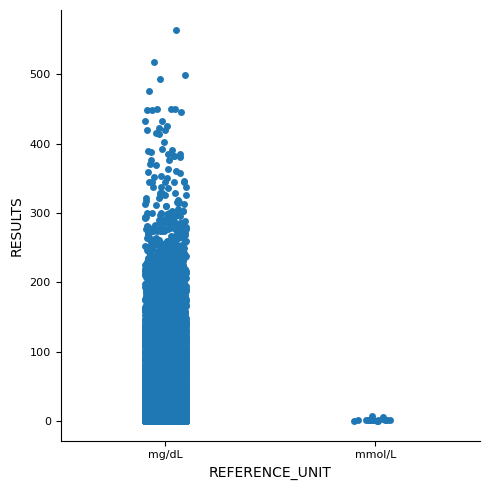

In [66]:
def plot_range(df: pd.DataFrame, match_str: str):
    data = df[
        df["COMPONENT_NAME"].isin(
            any_mismatch_units.index[any_mismatch_units.index.str.match(match_str)]
        )
    ]
    try:
        data["RESULTS"] = pd.to_numeric(data["RESULTS"])
    except:
        coerced = pd.to_numeric(data["RESULTS"], errors='coerce')
        display(data[coerced.isna()].groupby("RESULTS").all())
        display(data.groupby("REFERENCE_UNIT")["RESULTS"].describe())
        data["RESULTS"] = coerced#.fillna(-100)
        
    sns.catplot(
        x="REFERENCE_UNIT",
        y="RESULTS",
        data=data,
    )
    return data


# x = plot_range(crrt_df, "ABSOLUTE.*(QST)")
# The ranges are not the same. "X10*9/L" is between 0 and 10, the other is between 0 and 3x10e5.
# tmp = x[x["REFERENCE_UNIT"] == "X10*9/L"][["RESULTS", "REFERENCE_UNIT"]]
# tmp
plot_range(crrt_df, "CREATININE.*") # the units are the same range

## Conversion/Exploration

In [51]:
col = "METANEPHRINE"
display(crrt_df[crrt_df["COMPONENT_NAME"] == col])
display(cedars_df[cedars_df["COMPONENT_NAME"] == col])

,IP_PATIENT_ID,IP_ENCOUNTER_ID,PROC_ID,DESCRIPTION,COMPONENT_ID,COMPONENT_NAME,ORDER_TIME,RESULT_TIME,SPECIMN_TAKEN_TIME,RESULTS,REFERENCE_UNIT,LOINC_CODE
1348078,657D51DB5127616CB81CCCE93CF3401B,3E7A96536C94174FC07A2CC1748A9461,90194,"METANEPHRINES, FRACT, RAND UR",8011075,METANEPHRINE,12/08/2015 03:37:00,12/12/2015 09:22:00,12/08/2015 04:20:00,144,mcg/g cr,NaN
7854422,C583C610B82D56AC693308BDA3A734CC,A99F5ABC554C973E04F03A0544A9C5E9,35313,"METANEPHRINES, URINE 24 HOUR",8011072,METANEPHRINE,03/02/2016 23:52:00,03/10/2016 08:06:00,03/01/2016 21:00:00,80,mcg/24 h,NaN
8162399,32604B67FD6D5CD3F4B99D0335D9F6ED,66430949B9C7B004E5CD93B01D1DCC0E,35313,"METANEPHRINES, FRACT, 24HR UR",8011072,METANEPHRINE,02/18/2016 09:42:00,02/26/2016 10:48:00,02/17/2016 18:00:00,349,mcg/24 h,NaN
13732926,76B8A83A3F519AB2CB768AB62C5B2CC8,F6F81F5FE8FB6E9CFA7E2A90BC54CB61,35313,"METANEPHRINES, URINE 24 HOUR",8011072,METANEPHRINE,10/15/2015 03:46:00,10/23/2015 10:22:00,10/14/2015 02:00:00,352,mcg/24 h,NaN


,IP_PATIENT_ID,IP_ENCOUNTER_ID,COMPONENT_ID,COMPONENT_NAME,SPECIMN_TAKEN_TIME,PROC_ID,DESCRIPTION,ORDER_TIME,RESULT_TIME,RESULTS,REFERENCE_UNIT,LOINC_CODE
453412,NaN,37364578519,669,METANEPHRINE,2019-06-12 04:42:00,56392,"METANEPHRINES, FRACTIONATED, PLASMA",2019-06-12 00:05:00,2019-06-17 21:17:00,2.2,nmol/L,16974.0
466402,NaN,42542605990,669,METANEPHRINE,2019-07-02 16:56:00,56392,"METANEPHRINES, FRACTIONATED, PLASMA",2019-07-02 13:37:00,2019-07-08 23:35:00,<0.20,nmol/L,16974.0
770153,NaN,97823456749,669,METANEPHRINE,2017-09-06 05:45:00,56392,"METANEPHRINES, FRACTIONATED, PLASMA",2017-09-06 00:05:00,2017-09-09 11:25:00,<0.20,nmol/L,16974.0


The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


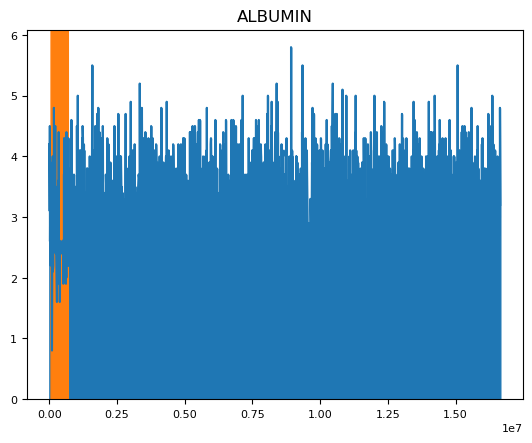

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


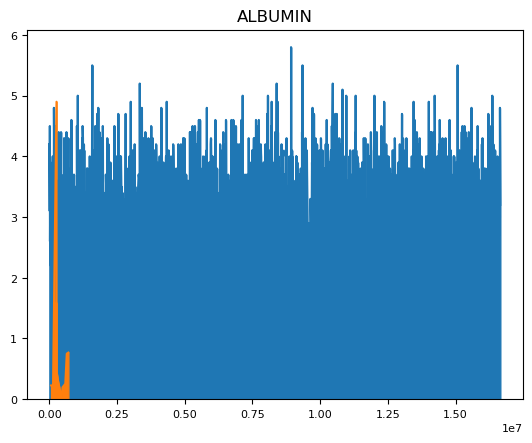

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


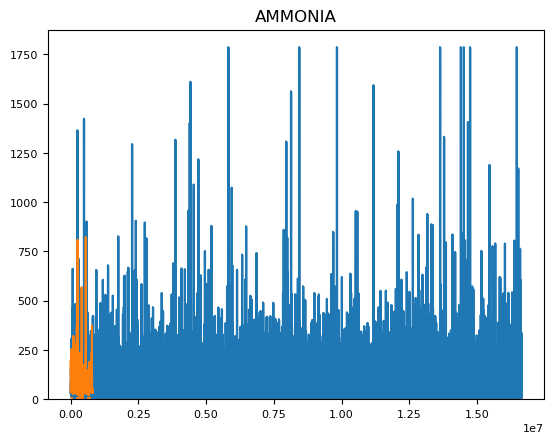

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


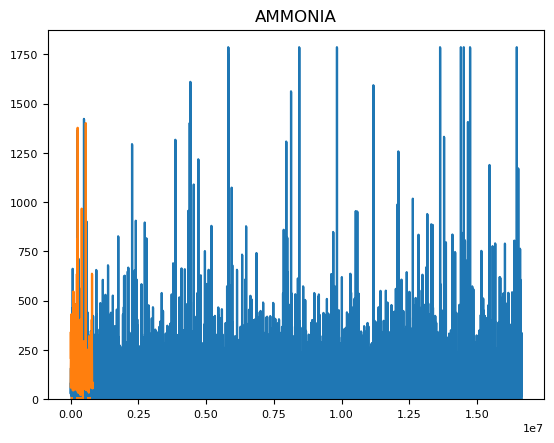

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


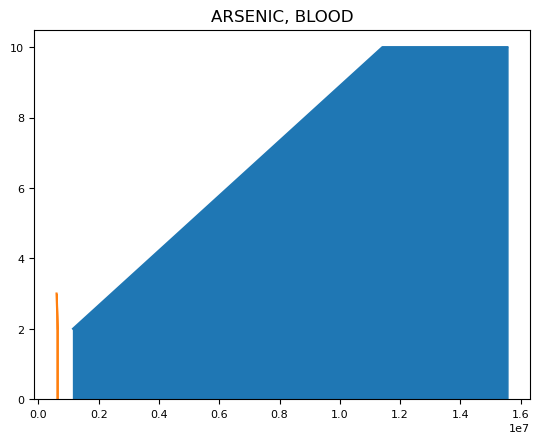

The default value of regex will change from True to False in a future version.


TypeError: no numeric data to plot

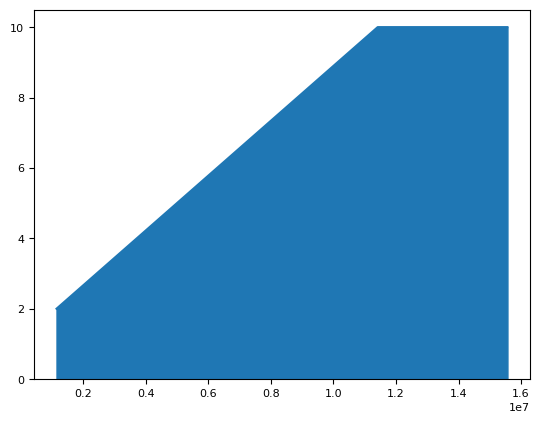

In [52]:
import matplotlib.pyplot as plt


def results_to_numeric(res: pd.Series) -> pd.Series:
    return pd.to_numeric(res.str.replace(">|<", ""), errors="coerce")


units_mapping = {
    # mg/dl -> g/dl
    "ALBUMIN": {
        # this looks weird with /1000 but right with /100
        "RESULTS": lambda df: results_to_numeric(df["RESULTS"]) / 100,
        "REFERENCE_UNIT": "g/dL",
    },
    # umol/l -> mcg/dl
    # molecular weight: https://unitslab.com/node/153
    "AMMONIA": {
        "RESULTS": lambda df: results_to_numeric(df["RESULTS"]) * 17.031 / 10,
        "REFERENCE_UNIT": "mcg/dL",
    },
    "ARSENIC, BLOOD": {},
}
for col, maping in units_mapping.items():
    print("=" * 100)
    # ucla_vals = crrt_df[crrt_df["DESCRIPTION"].str.contains(col)]
    # cedars_vals = cedars_df[cedars_df["COMPONENT_NAME"].str.contains(col)]
    ucla_vals = crrt_df[crrt_df["DESCRIPTION"] == col]
    cedars_vals = cedars_df[cedars_df["COMPONENT_NAME"] == col]
    # display(ucla_vals.head())
    # display(cedars_vals.head())
    results_to_numeric(ucla_vals["RESULTS"]).plot.area()
    results_to_numeric(cedars_vals["RESULTS"]).plot.area()
    plt.title(col)
    plt.show()
    plt.gcf().clear()

    results_to_numeric(ucla_vals["RESULTS"]).plot.area()
    cedars_vals.assign(**units_mapping[col])["RESULTS"].plot.area()
    plt.title(col)
    plt.show()
    plt.gcf().clear()